In [10]:
import uproot
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np


from python.analysis import Master, Plots
from python.analysis.shower_merging import SetPlotStyle

SetPlotStyle(True)

# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140


['abs_momentum;1', 'inel_momentum;1', 'cex_momentum;1', 'dcex_momentum;1', 'prod_momentum;1', 'total_inel_momentum;1', 'abs_KE;1', 'inel_KE;1', 'cex_KE;1', 'dcex_KE;1', 'prod_KE;1', 'total_inel_KE;1']


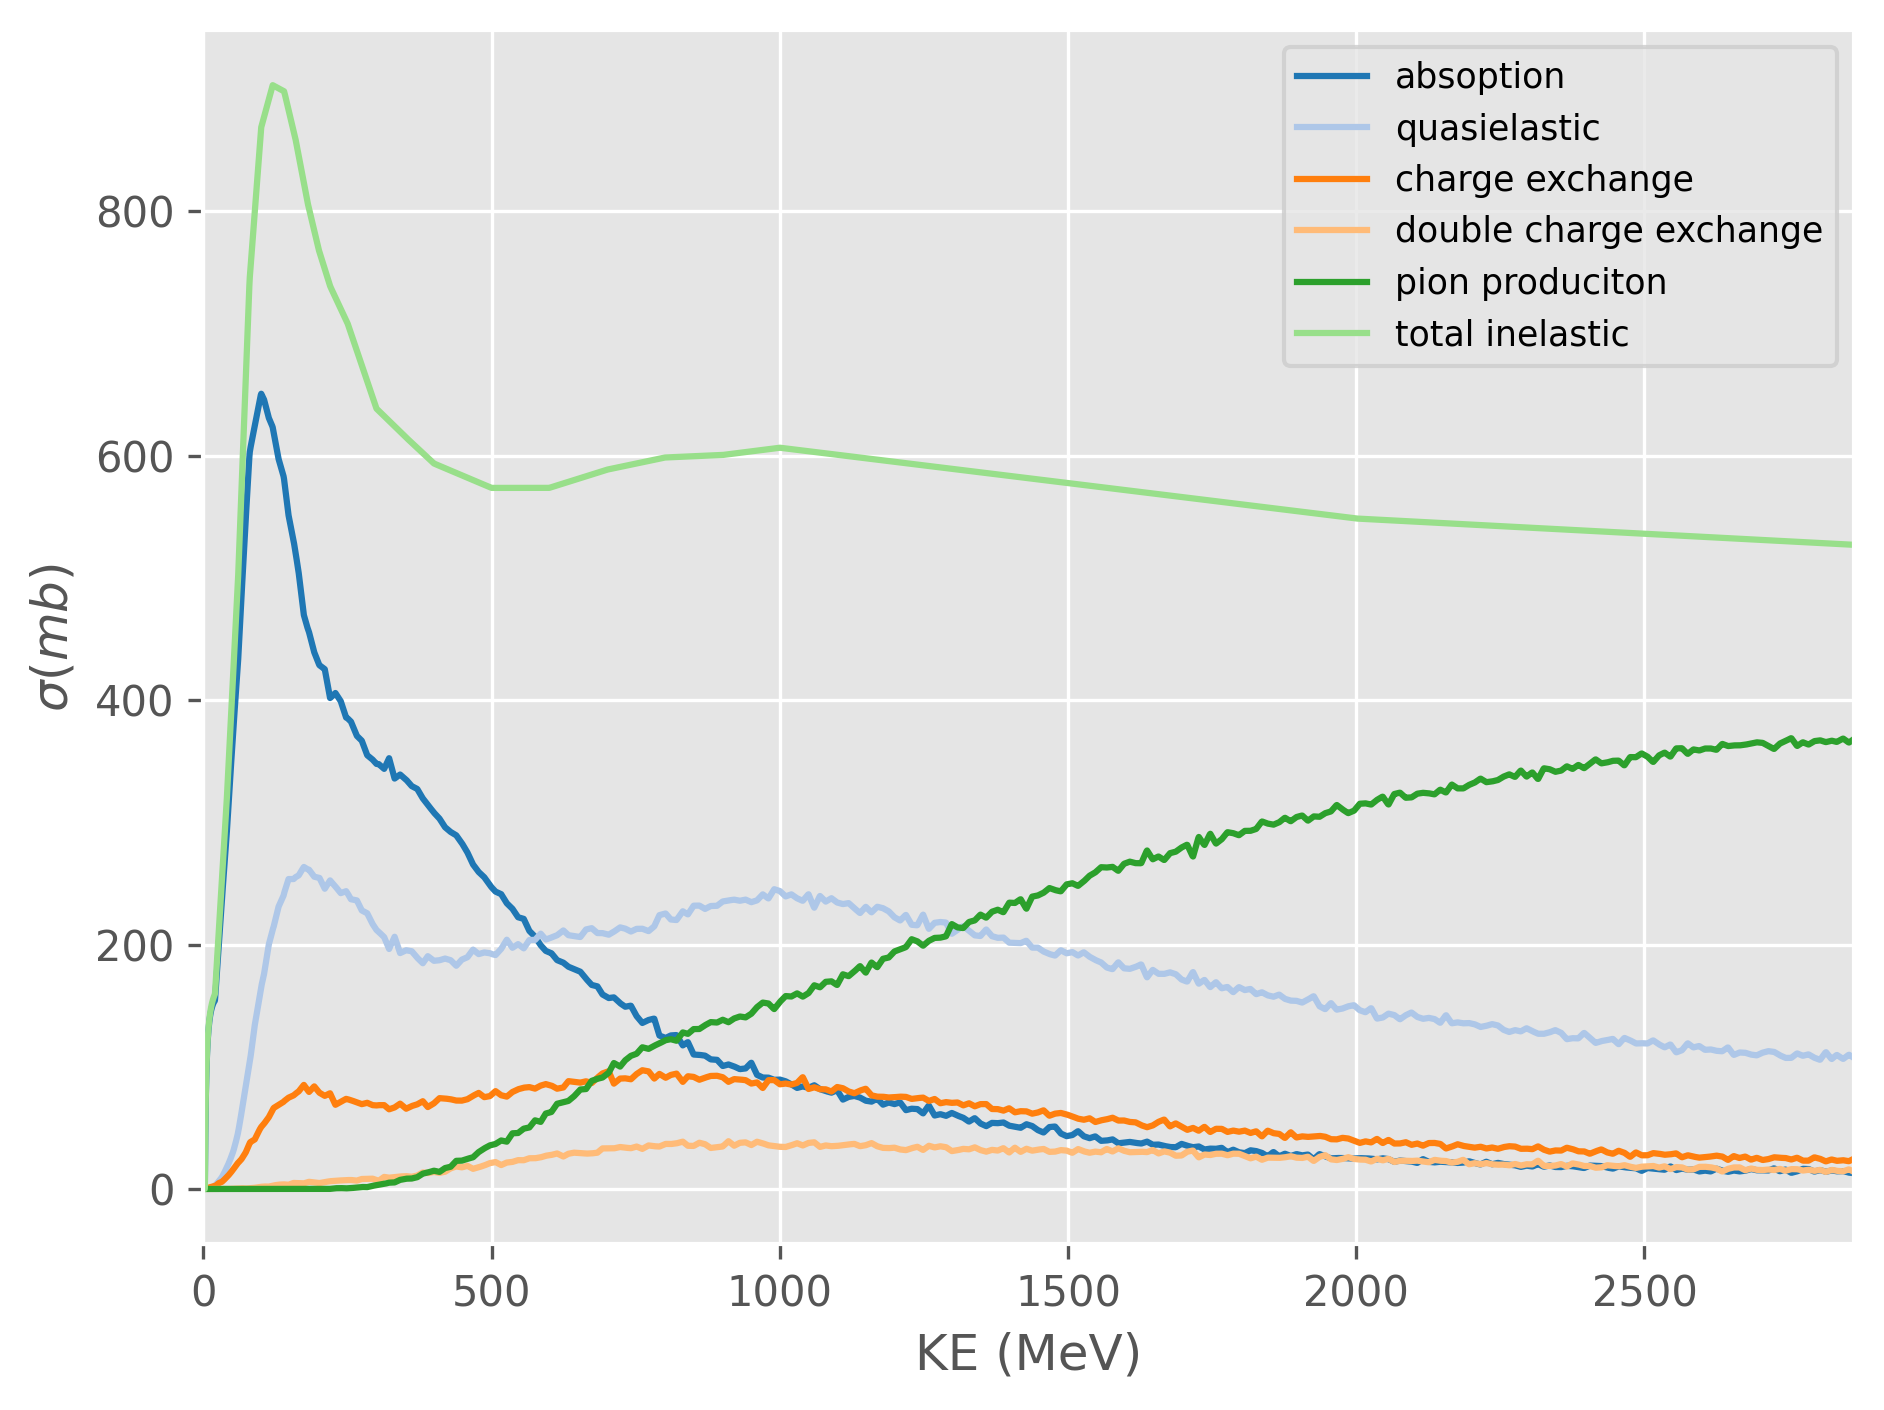

In [12]:

file = uproot.open("test/g4_xs.root")

labels = {"abs_KE;1" : "absoption", "inel_KE;1" : "quasielastic", "cex_KE;1" : "charge exchange", "dcex_KE;1" : "double charge exchange", "prod_KE;1" : "pion produciton", "total_inel_KE;1" : "total inelastic"}

print(file.keys())

for k in file.keys():
    if "KE" in k:
        g = file[k]
        Plots.Plot(g.all_members["fX"], g.all_members["fY"], label = labels[k], newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")

plt.xlim(0, max(file["abs_KE;1"].all_members["fX"]))
# mplcyberpunk.add_glow_effects()
plt.show()

In [2]:
events = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)

mask = events.trueParticlesBT.beam_pdg == 211
events.Filter([mask], [mask])

def AddVariable(name : str):
    events.trueParticles.LoadData(name, name)
    setattr(events.trueParticles, name, getattr(events.trueParticles, f"_TrueParticleData__{name}"))

AddVariable("true_beam_endProcess")
AddVariable("true_beam_traj_Z_SCE")
AddVariable("true_beam_traj_KE")

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [3]:
slice_width = 10 # cm
z_slice = np.arange(-10, 240, slice_width) # define z position slices
slice_num = z_slice//slice_width
print(z_slice)
print(slice_num)

[-10   0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160
 170 180 190 200 210 220 230]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]


We can then calculate what the average pion kinetic energy is in each slice (as a way to plot the cross section as a function of energy, but this isn't really the best approach)

In [4]:
energy = np.array([0] * len(slice_num))
count =  np.array([0] * len(slice_num))

for i in range(10000):
    for e, z in zip(events.trueParticles.true_beam_traj_KE[i], events.trueParticles.true_beam_traj_Z_SCE[i]):
        s = np.floor(z//10)
        if s < 0: s = min(slice_num)
        if s > max(slice_num): s = max(slice_num)
        energy[list(slice_num).index(s)] += e
        count[list(slice_num).index(s)] += 1

print(energy)
print(count)
print(energy/count)

[86262495   101811  4149445 35978925 41883157 19999217 15930800 13149943
 10712411  8806857  7332713  6224061  5214678  4371531  3750794  3190351
  2663942  2279334  1956991  1665629  1373829  1185647   975987   738087
  3612976]
[99388   134  5097 42144 50551 26053 21597 18506 15689 13396 11531 10187
  8886  7761  6923  6181  5384  4832  4376  3906  3407  3075  2718  2173
 16241]
[867.93672274 759.78358209 814.0955464  853.71405182 828.53270954
 767.63585767 737.63948697 710.57727224 682.79756517 657.42438041
 635.91301708 610.98075979 586.84199865 563.2690375  541.78737542
 516.15450574 494.78863299 471.71647351 447.21000914 426.42831541
 403.23715879 385.57626016 359.08278146 339.66267832 222.46019334]


Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


[37.8, 127, 293, 258, 54.4, 201, 68.6, ... 79, 59.1, 58.5, 115, 130, 76.3, 65.7]


/tmp/ipykernel_38528/443916358.py:27: RuntimeWarning: divide by zero encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)


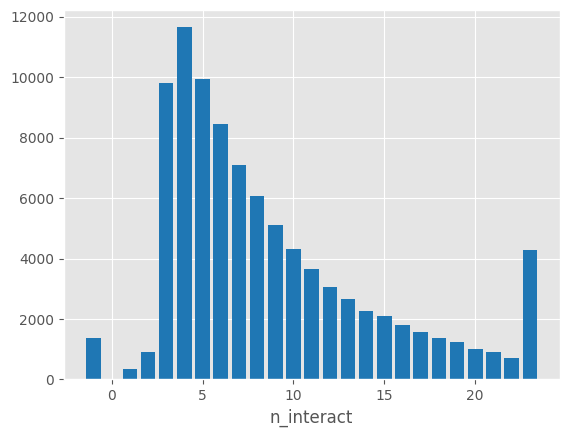

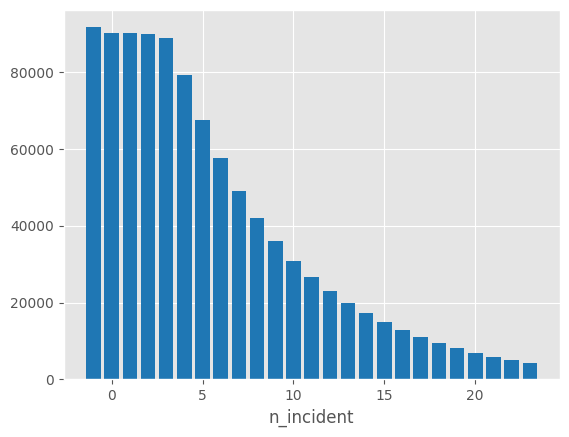

In [20]:
print(events.trueParticles.true_beam_traj_Z_SCE[:, -1])

#* create bins
n_interact = np.zeros(len(slice_num))
n_incident = np.zeros(len(slice_num))
 
#* loop though every beam particle end position
for i, j in zip(events.trueParticles.true_beam_traj_Z_SCE[:, -1], events.trueParticles.true_beam_endProcess):
    if j == "pi+Inelastic": # only count pion inelastic interactions so charge exchange, absorbtion and pion production
        end_slice = np.floor(i//10) 
        if i > max(z_slice): end_slice = max(slice_num) # decays past APA3 go into the overflow bin
        if i < 0: end_slice = min(slice_num) # decays not in the TPC go into the upstream loss bin
        
        index = np.where(slice_num == end_slice)[0][0]
        n_interact[index] += 1 # add 1 to interacting slice
        n_incident[0:index + 1] += 1 # add 1 to all previous slices and end_slice for n_incident

#* visualise the histograms
plt.figure()
plt.bar(slice_num, n_interact)
plt.xlabel("n_interact")

plt.figure()
plt.bar(slice_num, n_incident)
plt.xlabel("n_incident")

xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)

Plot the cross section as a function of slice number

<Figure size 640x480 with 0 Axes>

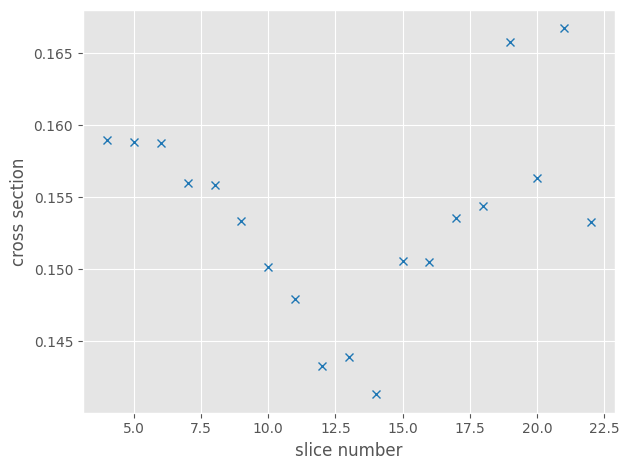

In [21]:
plt.figure()
Plots.Plot(slice_num[5:-1], xs[5:-1], xlabel = "slice number", ylabel = "cross section", linestyle = "", marker = "x")


Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

<Figure size 640x480 with 0 Axes>

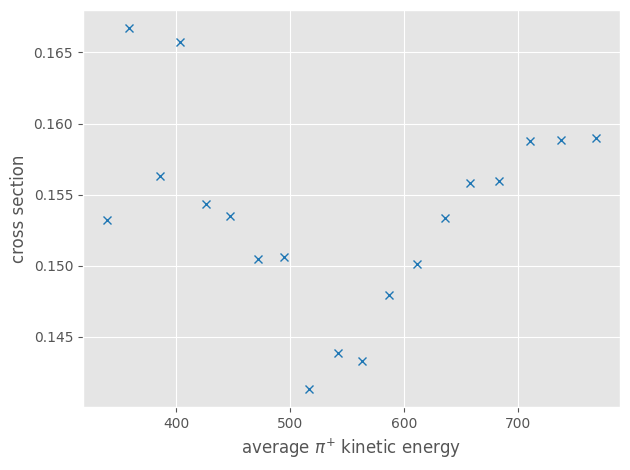

In [22]:

plt.figure()
Plots.Plot((energy/count)[5:-1], xs[5:-1], xlabel = "average $\pi^{+}$ kinetic energy", ylabel = "cross section", linestyle = "", marker = "x")


# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{E_{i}} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{E_{i}} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

In [121]:
dE = 50 # MeV
plim = 1000 # MeV, depends on the beam aprticle energy you are studying, this is the maximum kinetic energy one could have.

# plim = (plim ** 2 + 135**2)**0.5 - 135

e_slice = np.arange(plim, 0, -dE)
slice_num = np.array(list(reversed(e_slice//dE)))

print(e_slice)
print(slice_num)

[1000  950  900  850  800  750  700  650  600  550  500  450  400  350
  300  250  200  150  100   50]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

[762, 637, 261, 194, 759, 377, 824, 733, ... 863, 723, 689, 806, 701, 537, 694, 745]
[800, 931, 949, 806, 852, 844, 947, 940, ... 888, 892, 806, 921, 934, 824, 861, 852]
[4, 1, 1, 3, 2, 3, 1, 1, 3, 1, 3, 3, 1, 4, ... 2, 4, 1, 1, 1, 2, 2, 3, 1, 1, 3, 2, 2]
[4, 7, 14, 16, 4, 12, 3, 5, 12, 4, 5, 12, 4, ... 4, 3, 1, 8, 2, 5, 6, 3, 5, 9, 6, 5]
[0.0000e+00 2.1860e+04 4.6097e+04 5.6862e+04 5.0583e+04 3.9714e+04
 3.0137e+04 2.2656e+04 1.6978e+04 1.2622e+04 9.2820e+03 6.6260e+03
 4.6720e+03 3.2470e+03 2.1160e+03 1.3020e+03 6.6100e+02 2.1300e+02
 2.7000e+01 0.0000e+00]
[    0.  1136.  5877. 11136. 13190. 11856.  9633.  7505.  5700.  4362.
  3344.  2658.  1954.  1425.  1131.   814.   641.   448.   186.    27.]


/tmp/ipykernel_38528/3533149693.py:37: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)
/tmp/ipykernel_38528/3533149693.py:37: RuntimeWarning: divide by zero encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)
/tmp/ipykernel_38528/3533149693.py:37: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)


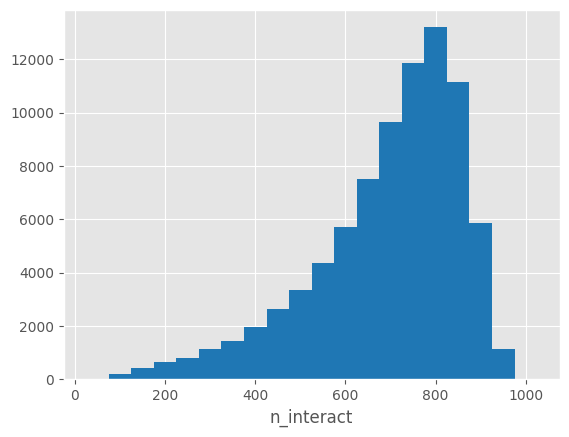

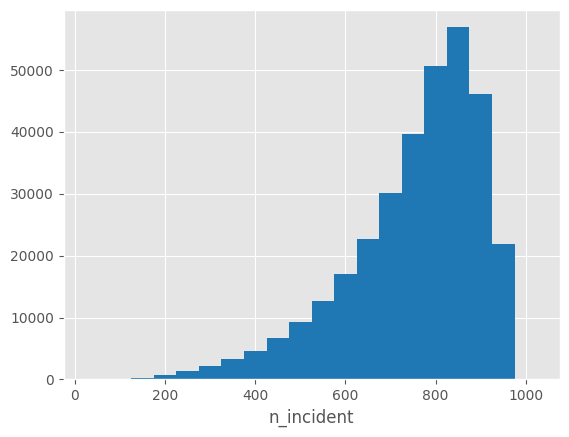

In [137]:
print(events.trueParticles.true_beam_traj_KE[:, -2]) # this is the kinetic energy the particle had before interacting i.e. index -1 is always 0 as it has intercted
print(events.trueParticles.true_beam_traj_KE[:, 0]) # Initial kinetic energy

final_slice = np.floor(plim - events.trueParticles.true_beam_traj_KE[:, -2])//dE
ini_slice = np.ceil(plim - events.trueParticles.true_beam_traj_KE[:, 0])//dE

# ini_slice[ini_slice < 0] = 0
# final_slice[final_slice < 0] = 0

print(ini_slice)
print(final_slice)

n_interact = np.zeros(len(slice_num))
n_incident = np.zeros(len(slice_num))


for i, f, j in zip(ini_slice, final_slice, events.trueParticles.true_beam_endProcess):
    if j == "pi+Inelastic": # only count pion inelastic interactions so charge exchange, absorbtion and pion production
        if i > max(slice_num) or i < min(slice_num): continue
        if f > max(slice_num) or f < min(slice_num): continue

        n_interact[int(f)] += 1
        n_incident[int(i) : int(f)] += 1

print(n_incident)
print(n_interact)

#* visualise the histograms
plt.figure()
plt.bar(e_slice, n_interact, width = 50)
plt.xlabel("n_interact")

plt.figure()
plt.bar(e_slice, n_incident, width = 50)
plt.xlabel("n_incident")

xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)


[1000  950  900  850  800  750  700  650  600  550  500  450  400  350
  300  250  200  150  100   50]
[       nan 0.05336603 0.13638349 0.21796022 0.30213203 0.35458359
 0.38513366 0.40235818 0.40906446 0.42401674 0.44670466 0.51273911
 0.54169093 0.57779669 0.76464115 0.98134142 3.49802157        nan
        nan       -inf]


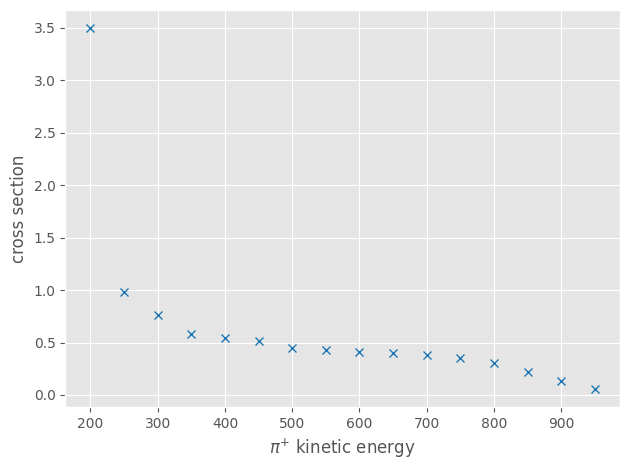

In [123]:
print(e_slice)
print(xs)

Plots.Plot(e_slice, xs, linestyle = "", marker = "x", xlabel = "$\pi^{+}$ kinetic energy", ylabel = "cross section")

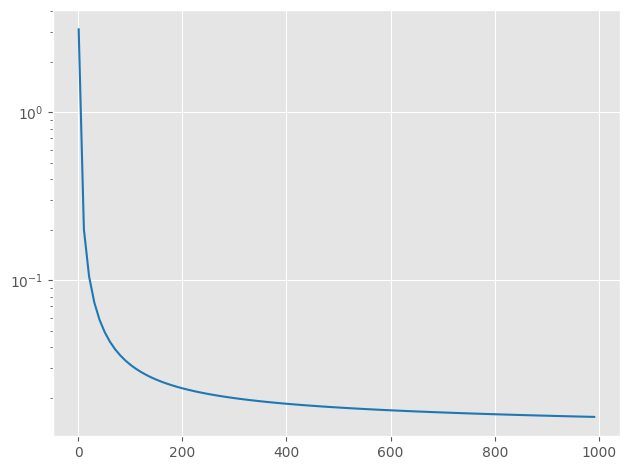

In [117]:
rho = 1.39 # [g/cm3] density of LAr
K = 0.307075 # [MeV cm2 / mol]
Z = 18 # LAr atomic number
A = 39.948 # [g/mol] LAr atomic mass
I = 188E-6 # [MeV] mean excitation energy
me = 0.511 # [MeV] electron mass

# density correction parameters
C = 5.2146
y0 = 0.2
y1 = 3
a = 0.19559
k = 3

pip_mass = 139
pip_charge = 1

def densityCorrection(beta, gamma):
    y = np.log10(beta * gamma)

    if y >= y1:
        delta = 2 * np.log(10)*y - C
    elif y0 <= y < y1:
        delta = 2 * np.log(10)*y - C + a * (y1 - y)**k
    else:
        delta = 0
    return delta

def meandEdX(KE, mass):
    gamma = (KE / mass) + 1
    beta = (1 - (1/(gamma**2)))**0.5

    w_max = 2 * me * (beta * gamma)**2 / (1 + (2 * me * (gamma/mass)) + (me/mass)**2)

    dEdX = (rho * K * Z * (1)**2) / ( A * beta**2 * (0.5 * np.log(2 * me * (gamma**2) * (beta**2) * w_max / (I**2))) - beta**2 - (densityCorrection(beta, gamma) / 2) )
    return dEdX


mean_dEdX = [meandEdX(i, pip_mass) for i in range(1, 1000, 10)]

Plots.Plot(range(1, 1000, 10), mean_dEdX, y_scale = "log")


[14.7006667  14.83017774 14.97067452 15.12396074 15.2922927  15.47853583
 15.68639173 15.92073607 16.18813614 16.49767045 16.86227758 17.30108034
 17.84361639 18.53807769 19.46878569 20.79763587 22.87876297 26.657877
 35.73730849 85.36591884]
[0.00030804 0.00031075 0.0003137  0.00031691 0.00032044 0.00032434
 0.0003287  0.00033361 0.00033921 0.0003457  0.00035334 0.00036253
 0.0003739  0.00038845 0.00040795 0.0004358  0.00047941 0.00055859
 0.00074885 0.00178877]


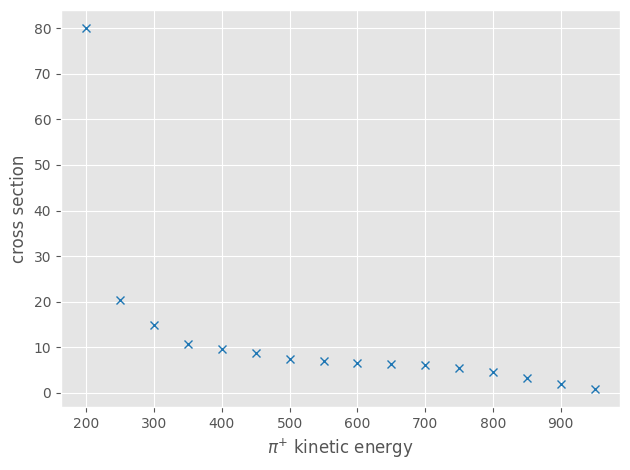

In [135]:
NA =6.02214076e23;
factor = 10**27 *  A / (rho * NA * dE) * np.array([meandEdX(e - 25, pip_mass) for e in e_slice])
print(factor)

slice_thickness = np.array([meandEdX(e - 25, pip_mass) for e in e_slice]) / dE
print(slice_thickness)
Plots.Plot(e_slice, xs * factor, linestyle = "", marker = "x", xlabel = "$\pi^{+}$ kinetic energy", ylabel = "cross section")


Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$

### Old notes
Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$